In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import re
import nltk
nltk.download('punkt')

# Load the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Define a function to normalize and tokenize the text
def normalize_and_tokenize(text):
    # Remove special characters and punctuation symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    return tokens

# Apply the function to the 'text' column of the train and test datasets
train_df['text'] = train_df['text'].apply(normalize_and_tokenize)
test_df['text'] = test_df['text'].apply(normalize_and_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip glove.6B.300d.txt

--2023-05-19 13:17:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-19 13:17:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-19 13:17:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

# Load the pre-trained GloVe embeddings
embeddings_index = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to get the embedding for a given word
def get_embedding(word):
    embedding = embeddings_index.get(word)
    if embedding is not None:
        return embedding
    else:
        return np.zeros(300)

# Define a function to get the embeddings for a given text
def get_text_embeddings(text):
    embeddings = []
    for word in text:
        embedding = get_embedding(word)
        embeddings.append(embedding)
    return embeddings

# Apply the function to the 'text' column of the train and test datasets
train_df['text_embeddings'] = train_df['text'].apply(get_text_embeddings)
test_df['text_embeddings'] = test_df['text'].apply(get_text_embeddings)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Epoch 1/50
171/171 [==============================] - 18s 95ms/step - loss: 1.2291 - accuracy: 0.5352 - val_loss: 0.7429 - val_accuracy: 0.7800
Epoch 2/50
171/171 [==============================] - 11s 65ms/step - loss: 0.7052 - accuracy: 0.7533 - val_loss: 0.5402 - val_accuracy: 0.8600
Epoch 3/50
171/171 [==============================] - 10s 59ms/step - loss: 0.5483 - accuracy: 0.8166 - val_loss: 0.4645 - val_accuracy: 0.8700
Epoch 4/50
171/171 [==============================] - 11s 61ms/step - loss: 0.4585 - accuracy: 0.8474 - val_loss: 0.4080 - val_accuracy: 0.8820
Epoch 5/50
171/171 [==============================] - 11s 63ms/step - loss: 0.3827 - accuracy: 0.8760 - val_loss: 0.4163 - val_accuracy: 0.8720
Epoch 6/50
171/171 [==============================] - 13s 74ms/step - loss: 0.3322 - accuracy: 0.8931 - val_loss: 0.3692 - val_accuracy: 0.8760
Epoch 7/50
171/171 [=================

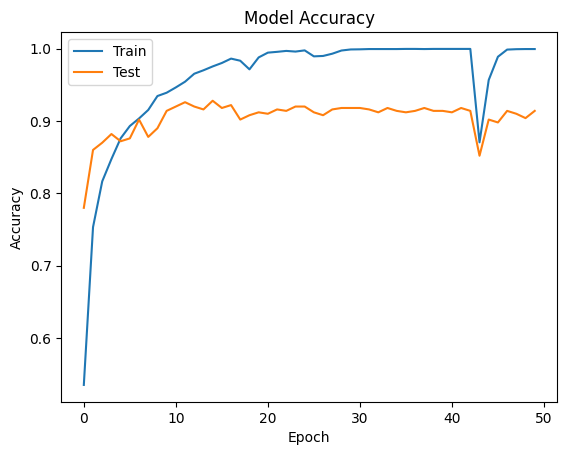

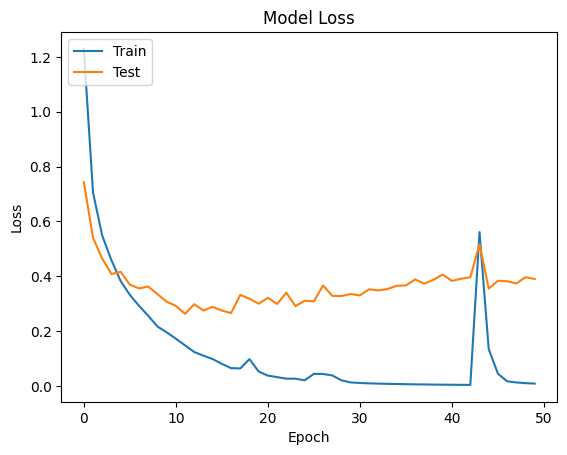

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Set the number of classes
num_classes = 6

# Convert the 'label-coarse' column to one-hot encoded labels
y_train = to_categorical(train_df['label-coarse'], num_classes=num_classes)
y_test = to_categorical(test_df['label-coarse'], num_classes=num_classes)

# Define the maximum sequence length (you can choose a different value)
max_seq_length = 100

# Pad or truncate the 'text_embeddings' sequences to have the same length
X_train = pad_sequences(train_df['text_embeddings'], maxlen=max_seq_length, dtype='float32')
X_test = pad_sequences(test_df['text_embeddings'], maxlen=max_seq_length, dtype='float32')

# Define the input shape
input_shape = (max_seq_length, 300)

# Create the model
model = Sequential()
model.add(LSTM(25, input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and save the training history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot the train and test accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the train and test loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded test labels back to class labels
y_test_classes = y_test.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Compute the classification report
report = classification_report(y_test_classes, y_pred_classes)

# Evaluate the model on the test dataset
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the confusion matrix and classification report
print(f'Test Accuracy: {test_acc:.2f}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)

16/16 [==============================] - 2s 61ms/step
Test Accuracy: 0.91
Confusion Matrix:
[[136   1   1   0   0   0]
 [  8  77   1   4   0   4]
 [  2   0   7   0   0   0]
 [  2   0   0  59   0   4]
 [  6   0   0   0 105   2]
 [  4   3   0   1   0  73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       138
           1       0.95      0.82      0.88        94
           2       0.78      0.78      0.78         9
           3       0.92      0.91      0.91        65
           4       1.00      0.93      0.96       113
           5       0.88      0.90      0.89        81

    accuracy                           0.91       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.92      0.91      0.91       500



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Epoch 1/50
171/171 [==============================] - 34s 178ms/step - loss: 0.9949 - accuracy: 0.6192 - val_loss: 0.5394 - val_accuracy: 0.8420
Epoch 2/50
171/171 [==============================] - 28s 164ms/step - loss: 0.5275 - accuracy: 0.8236 - val_loss: 0.4159 - val_accuracy: 0.8680
Epoch 3/50
171/171 [==============================] - 30s 172ms/step - loss: 0.4036 - accuracy: 0.8575 - val_loss: 0.3954 - val_accuracy: 0.8820
Epoch 4/50
171/171 [==============================] - 27s 160ms/step - loss: 0.3066 - accuracy: 0.8929 - val_loss: 0.3024 - val_accuracy: 0.9040
Epoch 5/50
171/171 [==============================] - 29s 168ms/step - loss: 0.2410 - accuracy: 0.9143 - val_loss: 0.2794 - val_accuracy: 0.9080
Epoch 6/50
171/171 [==============================] - 28s 166ms/step - loss: 0.1855 - accuracy: 0.9376 - val_loss: 0.2631 - val_accuracy: 0.9160
Epoch 7/50
171/171 [===========

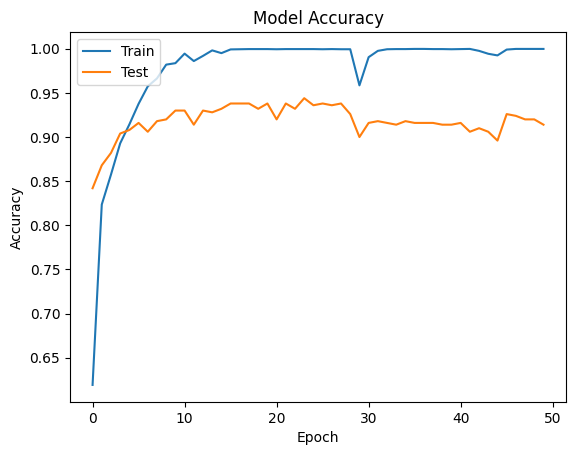

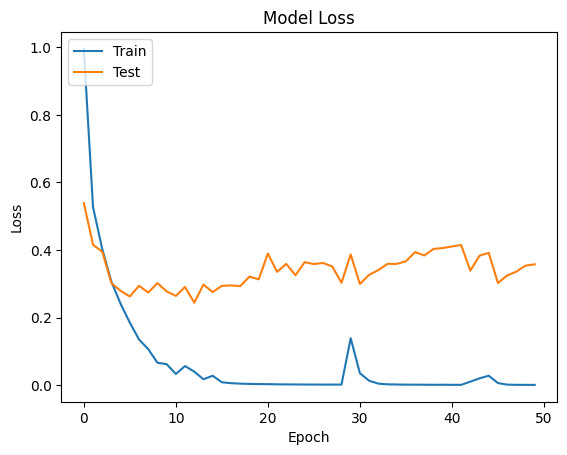

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Set the number of classes
num_classes = 6

# Convert the 'label-coarse' column to one-hot encoded labels
y_train = to_categorical(train_df['label-coarse'], num_classes=num_classes)
y_test = to_categorical(test_df['label-coarse'], num_classes=num_classes)

# Define the maximum sequence length (you can choose a different value)
max_seq_length = 100

# Pad or truncate the 'text_embeddings' sequences to have the same length
X_train = pad_sequences(train_df['text_embeddings'], maxlen=max_seq_length, dtype='float32')
X_test = pad_sequences(test_df['text_embeddings'], maxlen=max_seq_length, dtype='float32')

# Define the input shape
input_shape = (max_seq_length, 300)

# Create the model
model = Sequential()
model.add(LSTM(100, input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and save the training history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot the train and test accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the train and test loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded test labels back to class labels
y_test_classes = y_test.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Compute the classification report
report = classification_report(y_test_classes, y_pred_classes)

# Evaluate the model on the test dataset
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the confusion matrix and classification report
print(f'Test Accuracy: {test_acc:.2f}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)

16/16 [==============================] - 1s 52ms/step
Test Accuracy: 0.91
Confusion Matrix:
[[130   1   6   0   1   0]
 [ 10  75   0   3   3   3]
 [  1   0   8   0   0   0]
 [  1   0   0  62   0   2]
 [  5   0   0   0 106   2]
 [  2   2   0   0   1  76]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       138
           1       0.96      0.80      0.87        94
           2       0.57      0.89      0.70         9
           3       0.95      0.95      0.95        65
           4       0.95      0.94      0.95       113
           5       0.92      0.94      0.93        81

    accuracy                           0.91       500
   macro avg       0.87      0.91      0.88       500
weighted avg       0.92      0.91      0.91       500



In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical

# Set the number of classes
num_coarse_classes = 6
num_fine_classes = 50

# Convert the 'label-coarse' and 'label-fine' columns to one-hot encoded labels
y_coarse_train = to_categorical(train_df['label-coarse'], num_classes=num_coarse_classes)
y_coarse_test = to_categorical(test_df['label-coarse'], num_classes=num_coarse_classes)
y_fine_train = to_categorical(train_df['label-fine'], num_classes=num_fine_classes)
y_fine_test = to_categorical(test_df['label-fine'], num_classes=num_fine_classes)

# Define the maximum sequence length
max_seq_length = 100

# Add a <PAD> token at the end of each text sequence
train_df['padded_text'] = train_df['text'].apply(lambda x: x + ['<PAD>'])
test_df['padded_text'] = test_df['text'].apply(lambda x: x + ['<PAD>'])

# Get the embeddings for the padded text sequences
X_train = train_df['padded_text'].apply(get_text_embeddings)
X_test = test_df['padded_text'].apply(get_text_embeddings)

# Pad or truncate the 'text_embeddings' sequences to have the same length
X_train = pad_sequences(X_train, maxlen=max_seq_length + 1, dtype='float32')
X_test = pad_sequences(X_test, maxlen=max_seq_length + 1, dtype='float32')

# Define the input shape
input_shape = (max_seq_length + 1, 300)

# Create the input layer
inputs = Input(shape=input_shape)

# Create the LSTM layer
lstm_outputs = LSTM(25, return_sequences=True)(inputs)

# Create the coarse and fine output layers
coarse_outputs = Dense(num_coarse_classes, activation='softmax')(lstm_outputs[:, -2, :])
fine_outputs = Dense(num_fine_classes, activation='softmax')(lstm_outputs[:, -1, :])

# Create the model
model = Model(inputs=inputs, outputs=[coarse_outputs, fine_outputs])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, [y_coarse_train, y_fine_train], validation_data=(X_test, [y_coarse_test, y_fine_test]), epochs=50, batch_size=32)

Epoch 1/50
171/171 [==============================] - 17s 78ms/step - loss: 4.5655 - dense_5_loss: 1.3538 - dense_6_loss: 3.2117 - dense_5_accuracy: 0.4740 - dense_6_accuracy: 0.2412 - val_loss: 3.6503 - val_dense_5_loss: 0.9092 - val_dense_6_loss: 2.7411 - val_dense_5_accuracy: 0.6880 - val_dense_6_accuracy: 0.4760
Epoch 2/50
171/171 [==============================] - 10s 60ms/step - loss: 3.2274 - dense_5_loss: 0.8250 - dense_6_loss: 2.4024 - dense_5_accuracy: 0.7192 - dense_6_accuracy: 0.3933 - val_loss: 3.0367 - val_dense_5_loss: 0.6797 - val_dense_6_loss: 2.3570 - val_dense_5_accuracy: 0.7660 - val_dense_6_accuracy: 0.4800
Epoch 3/50
171/171 [==============================] - 11s 62ms/step - loss: 2.6299 - dense_5_loss: 0.6137 - dense_6_loss: 2.0162 - dense_5_accuracy: 0.7940 - dense_6_accuracy: 0.4906 - val_loss: 2.5285 - val_dense_5_loss: 0.5300 - val_dense_6_loss: 1.9985 - val_dense_5_accuracy: 0.8400 - val_dense_6_accuracy: 0.5580
Epoch 4/50
171/171 [==========================

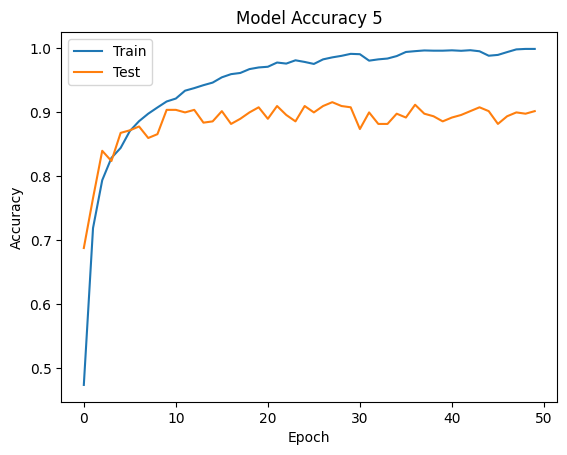

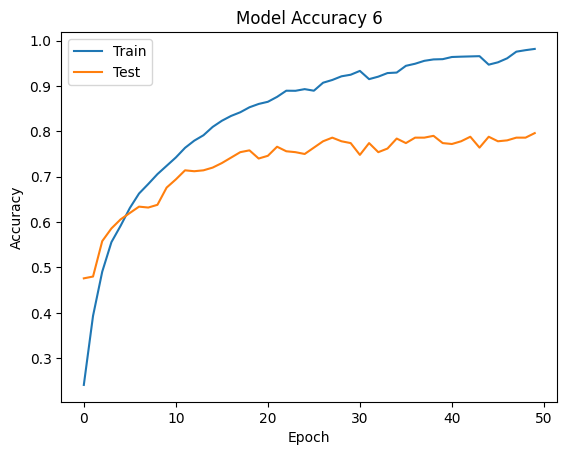

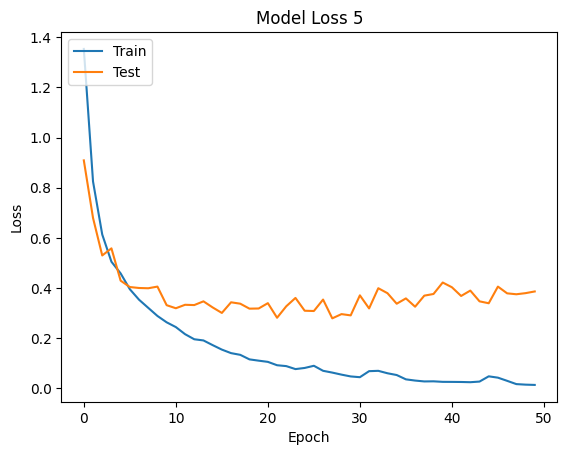

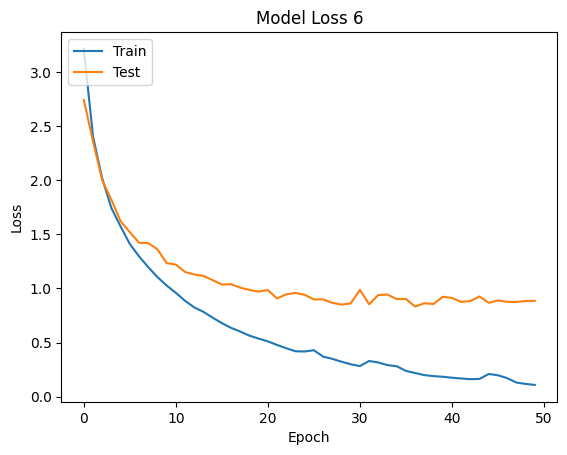

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and test accuracy over epochs
plt.plot(history.history['dense_5_accuracy'])
plt.plot(history.history['val_dense_5_accuracy'])
plt.title('Model Accuracy 5')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_6_accuracy'])
plt.plot(history.history['val_dense_6_accuracy'])
plt.title('Model Accuracy 6')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the train and test loss over epochs
plt.plot(history.history['dense_5_loss'])
plt.plot(history.history['val_dense_5_loss'])
plt.title('Model Loss 5')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_6_loss'])
plt.plot(history.history['val_dense_6_loss'])
plt.title('Model Loss 6')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical

# Set the number of classes
num_coarse_classes = 6
num_fine_classes = 50

# Convert the 'label-coarse' and 'label-fine' columns to one-hot encoded labels
y_coarse_train = to_categorical(train_df['label-coarse'], num_classes=num_coarse_classes)
y_coarse_test = to_categorical(test_df['label-coarse'], num_classes=num_coarse_classes)
y_fine_train = to_categorical(train_df['label-fine'], num_classes=num_fine_classes)
y_fine_test = to_categorical(test_df['label-fine'], num_classes=num_fine_classes)

# Define the maximum sequence length
max_seq_length = 100

# Add a <PAD> token at the end of each text sequence
train_df['padded_text'] = train_df['text'].apply(lambda x: x + ['<PAD>'])
test_df['padded_text'] = test_df['text'].apply(lambda x: x + ['<PAD>'])

# Get the embeddings for the padded text sequences
X_train = train_df['padded_text'].apply(get_text_embeddings)
X_test = test_df['padded_text'].apply(get_text_embeddings)

# Pad or truncate the 'text_embeddings' sequences to have the same length
X_train = pad_sequences(X_train, maxlen=max_seq_length + 1, dtype='float32')
X_test = pad_sequences(X_test, maxlen=max_seq_length + 1, dtype='float32')

# Define the input shape
input_shape = (max_seq_length + 1, 300)

# Create the input layer
inputs = Input(shape=input_shape)

# Create the LSTM layer
lstm_outputs = LSTM(100, return_sequences=True)(inputs)

# Create the coarse and fine output layers
coarse_outputs = Dense(num_coarse_classes, activation='softmax')(lstm_outputs[:, -2, :])
fine_outputs = Dense(num_fine_classes, activation='softmax')(lstm_outputs[:, -1, :])

# Create the model
model = Model(inputs=inputs, outputs=[coarse_outputs, fine_outputs])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, [y_coarse_train, y_fine_train], validation_data=(X_test, [y_coarse_test, y_fine_test]), epochs=50, batch_size=32)

Epoch 1/50
171/171 [==============================] - 34s 177ms/step - loss: 3.6070 - dense_9_loss: 1.0609 - dense_10_loss: 2.5461 - dense_9_accuracy: 0.5952 - dense_10_accuracy: 0.3626 - val_loss: 2.5547 - val_dense_9_loss: 0.6067 - val_dense_10_loss: 1.9480 - val_dense_9_accuracy: 0.7860 - val_dense_10_accuracy: 0.5640
Epoch 2/50
171/171 [==============================] - 28s 163ms/step - loss: 2.0790 - dense_9_loss: 0.5469 - dense_10_loss: 1.5321 - dense_9_accuracy: 0.8098 - dense_10_accuracy: 0.6027 - val_loss: 1.9539 - val_dense_9_loss: 0.4610 - val_dense_10_loss: 1.4929 - val_dense_9_accuracy: 0.8520 - val_dense_10_accuracy: 0.6360
Epoch 3/50
171/171 [==============================] - 28s 166ms/step - loss: 1.5752 - dense_9_loss: 0.4274 - dense_10_loss: 1.1479 - dense_9_accuracy: 0.8542 - dense_10_accuracy: 0.6911 - val_loss: 1.4985 - val_dense_9_loss: 0.3376 - val_dense_10_loss: 1.1608 - val_dense_9_accuracy: 0.9020 - val_dense_10_accuracy: 0.7000
Epoch 4/50
171/171 [===========

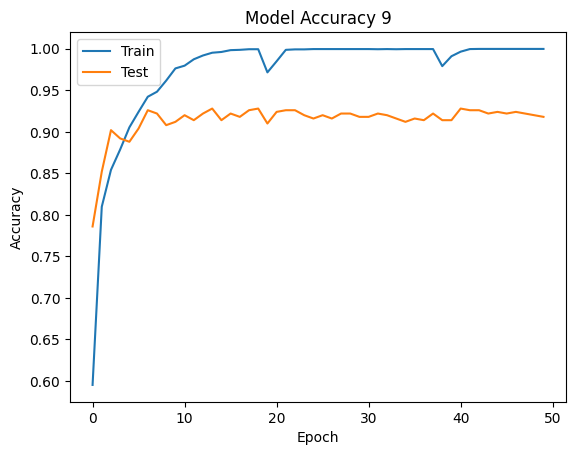

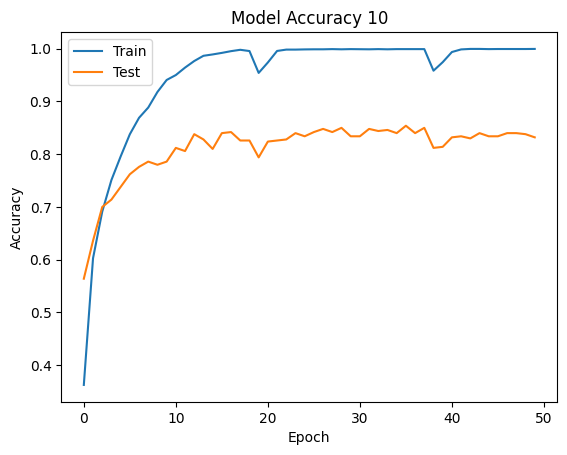

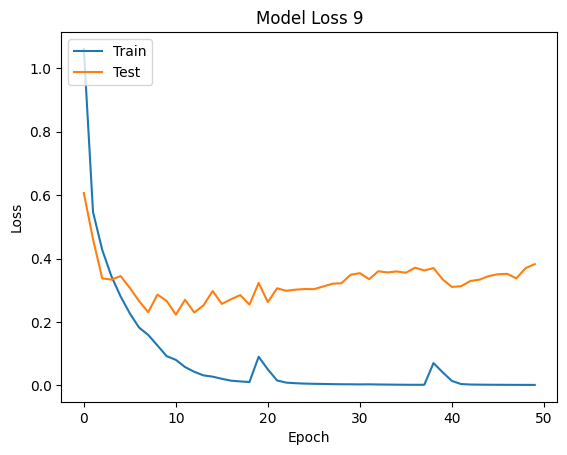

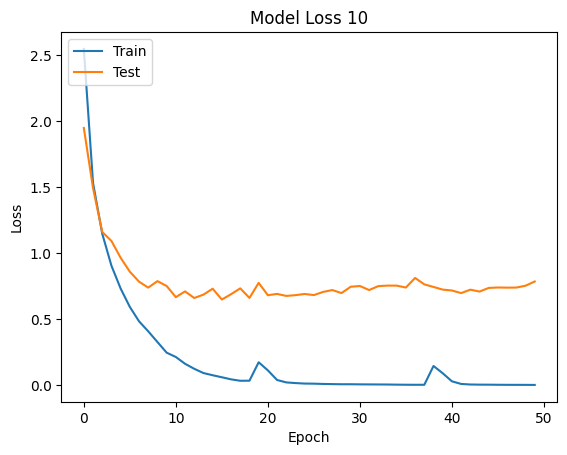

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and test accuracy over epochs
plt.plot(history.history['dense_9_accuracy'])
plt.plot(history.history['val_dense_9_accuracy'])
plt.title('Model Accuracy 9')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_10_accuracy'])
plt.plot(history.history['val_dense_10_accuracy'])
plt.title('Model Accuracy 10')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the train and test loss over epochs
plt.plot(history.history['dense_9_loss'])
plt.plot(history.history['val_dense_9_loss'])
plt.title('Model Loss 9')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_10_loss'])
plt.plot(history.history['val_dense_10_loss'])
plt.title('Model Loss 10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()